In [73]:
import tifffile
import scipy.io
import numpy as np
from PIL import Image
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage import filters,measure
from skimage.filters import threshold_local
from skimage.measure import label, regionprops
from skimage.transform import estimate_transform, warp
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

In [74]:
def generate_df(root,frame, variable_name):
    image = []
    for i in range(1,frame+1):


        mat = root+'/Frame_'+str(i)+'/worksapce.mat'
        # Load the .mat file
        mat_data = scipy.io.loadmat(mat)


        # Access a specific variable by name
        # variable_name = 'pixxx'  # Replace with the actual variable name
        if variable_name in mat_data:
            # image = np.mat_data[variable_name]
            specific_data = mat_data[variable_name]
        # if i ==1:
        #     image = specific_data
        # else:
        #     image = np.stack([image,specific_data],axis = 0)
            image.append(specific_data)
    Image = np.array(image)

    return Image

In [75]:
def save_image(path,image,Type):
    if Type == 0:
        tifffile.imwrite(path+'origin.tif', image)
    elif Type == 1:
        imsr = Image.fromarray(image)
        imsr.save(path+'binary_mask.tif')
    elif Type == 2:
        tifffile.imwrite(path+'masked.tif',image)

In [76]:
path = f"/Volumes/Tianxiao/20250430_SPAD/"


In [77]:
for dirs in os.listdir(path):
    if dirs != 'PinHole':
        data = generate_df(os.path.join(path,dirs),1000,'pixxx_reduction')
        save_image(os.path.join(path,dirs),data,0)

/opt/anaconda3/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab._mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


KeyboardInterrupt: 

The following cell split the channels from the orignal image.

In [47]:
def split_tiff_stack(input_tiff, output_dir):
    # Read all frames in the TIFF
    os.makedirs(output_dir, exist_ok=True)
    data = tifffile.imread(input_tiff)
    # data shape examples:
    #   Grayscale: (num_frames, height, width)
    #   Color:     (num_frames, height, width, channels)

    num_frames, height, width = data.shape
    half_w = width // 2
    left_stack    = data[:, :, :half_w]
    right_stack = data[:, :, half_w:]
    name = os.path.basename(input_tiff)
    red = 'Red_'+name
    green = 'Green_'+name
    tifffile.imwrite(os.path.join(output_dir,red), left_stack)
    tifffile.imwrite(os.path.join(output_dir,green), right_stack)

# Example usage:
if __name__ == "__main__":
    root_directory = "/Volumes/Tianxiao/20250430_SPAD/"
    output_directory = "/Volumes/Tianxiao/Split/"
    for current_dir, dirs, files in os.walk(root_directory):
        for filename in files:
            # Check if the file is a TIFF (case-insensitive)
            if filename.lower().endswith('.tif'):
                if filename[0] !='.':
                    img_path = os.path.join(current_dir, filename)
                    split_tiff_stack(img_path, output_directory)

KeyboardInterrupt: 

The following cell is used to split the channel from the image with LED on.

In [54]:
mask_path = f'/Volumes/Tianxiao/20250430_SPAD/PinHole/binary_mask.tif'
mask = imread(mask_path)
left_stack    = mask[:, :64]
right_stack = mask[:, 64:]
name = os.path.basename(mask_path)
red = 'Red_'+name
green = 'Green_'+name
tifffile.imwrite(os.path.join("/Volumes/Tianxiao/Split/",red), left_stack)
tifffile.imwrite(os.path.join("/Volumes/Tianxiao/Split/",green), right_stack)
mask.shape

(128, 128)

In [55]:
import numpy as np
from skimage.measure import label, regionprops
from skimage.transform import estimate_transform, warp
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

# ===========================================================
# 1. Suppose you have already loaded or created your 2D
#    binary masks: red_mask, green_mask.
#    Both are the same size, e.g. (64, 128).
#    Example (Pseudocode):
#
#    red_mask = np.load("red_mask.npy")    # shape [H, W]
#    green_mask = np.load("green_mask.npy")# shape [H, W]
# ===========================================================

# For demonstration, let's assume the variables red_mask and green_mask
# are already defined in your environment.
red_mask = imread('/Volumes/Tianxiao/Split/Red_binary_mask.tif')
green_mask = imread('/Volumes/Tianxiao/Split/green_binary_mask.tif')
# 2. Label connected components for each mask
red_labels = label(red_mask, connectivity=2)
green_labels = label(green_mask, connectivity=2)

# 3. Extract centroid positions of each component
red_props = regionprops(red_labels)
green_props = regionprops(green_labels)

# regionprops returns centroid in (row, col) format => (y, x)
red_centroids = np.array([prop.centroid for prop in red_props])     # shape [N_red, 2]
green_centroids = np.array([prop.centroid for prop in green_props]) # shape [N_green, 2]

# 4. Match red pinholes to green pinholes using minimal distance (Hungarian algorithm)
#    NOTE: This step assumes the same number of pinholes in both masks.
#    If that’s not guaranteed, you can either:
#       (a) filter out outliers or
#       (b) use a robust method like RANSAC.
cost_matrix = distance_matrix(red_centroids, green_centroids)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

matched_red_points   = red_centroids[row_ind]   # Nx2
matched_green_points = green_centroids[col_ind] # Nx2

# 5. Estimate the affine transformation that maps red → green
transform = estimate_transform(
    'affine',
    src=matched_red_points,
    dst=matched_green_points
)
print("Affine transform matrix:\n", transform.params)

# 6. Warp the red mask using the estimated transform
#    We use nearest-neighbor interpolation (order=0) to keep it binary.
aligned_red_mask = warp(
    red_mask.astype(float),          # warp requires float or double
    inverse_map=transform.inverse,   # transform is from red→green, so use inverse
    output_shape=green_mask.shape,   # same shape as green_mask
    order=0                          # nearest-neighbor
) > 0.5  # re-binarize

# 7. Now aligned_red_mask should align closely with green_mask.
#    You can compare them visually or measure pixel overlap, etc.


Affine transform matrix:
 [[ 0.97222787 -0.01029893  1.13477869]
 [-0.01798549  0.96368113  1.33743228]
 [ 0.          0.          1.        ]]


Red mask shape: (128, 64)
Green mask shape: (128, 64)
Number of pinholes in Red mask:    331
Number of pinholes in Green mask:  356
Inlier matches (red channel):
 [[  5.          25.        ]
 [  6.          34.        ]
 [  7.          21.        ]
 [  7.          47.        ]
 [  7.          51.        ]
 [  9.          12.        ]
 [  9.          16.        ]
 [  9.5         25.        ]
 [  9.          38.        ]
 [ 11.          29.        ]
 [ 11.          42.        ]
 [ 12.           7.        ]
 [ 12.          20.        ]
 [ 12.          46.        ]
 [ 13.          11.        ]
 [ 13.          16.        ]
 [ 14.          24.        ]
 [ 14.          55.        ]
 [ 15.          29.        ]
 [ 15.          33.        ]
 [ 15.          42.        ]
 [ 16.           7.        ]
 [ 16.          20.        ]
 [ 16.          46.        ]
 [ 17.          11.        ]
 [ 17.          15.        ]
 [ 18.          24.        ]
 [ 18.          37.        ]
 [ 18.5         54.      

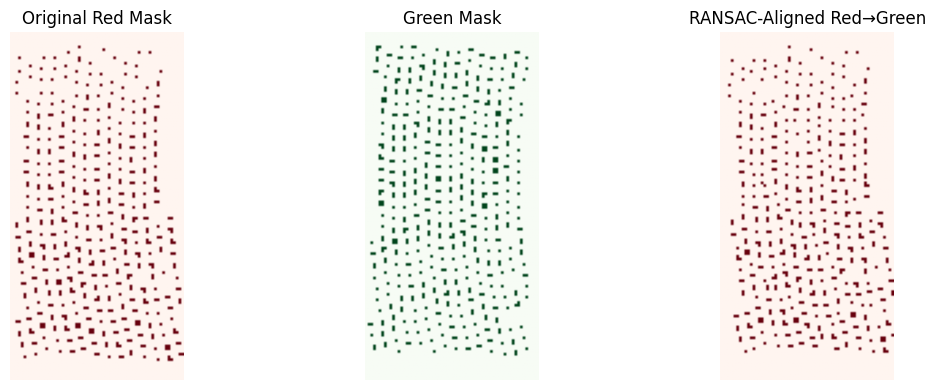

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.measure import label, regionprops, ransac
from skimage.transform import AffineTransform, warp
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

def main():
    """
    RANSAC-based robust registration of two binary mask TIFF images
    containing pinholes in red vs. green channels.
    """

    # -------------------------------------------------------
    # 1. LOAD YOUR BINARY MASK TIFF FILES
    #    (Ensure they're single-plane binary or threshold them)
    # -------------------------------------------------------
    red_mask_raw = imread('/Volumes/Tianxiao/Split/Red_binary_mask.tif')
    green_mask_raw = imread('/Volumes/Tianxiao/Split/green_binary_mask.tif')

    # Convert to boolean if necessary (assuming >0 = True)
    red_mask = (red_mask_raw > 0)
    green_mask = (green_mask_raw > 0)

    print("Red mask shape:", red_mask.shape)
    print("Green mask shape:", green_mask.shape)

    # -------------------------------------------------------
    # 2. LABEL CONNECTED COMPONENTS & EXTRACT PINHOLE CENTROIDS
    # -------------------------------------------------------
    red_labels = label(red_mask, connectivity=2)
    green_labels = label(green_mask, connectivity=2)

    red_props = regionprops(red_labels)
    green_props = regionprops(green_labels)

    # Extract (y, x) centroids
    red_centroids = np.array([p.centroid for p in red_props])     # shape [N_red, 2]
    green_centroids = np.array([p.centroid for p in green_props]) # shape [N_green, 2]

    print("Number of pinholes in Red mask:   ", len(red_centroids))
    print("Number of pinholes in Green mask: ", len(green_centroids))

    # -------------------------------------------------------
    # 3. MATCH PINHOLES (Hungarian for minimal total distance)
    #
    #    This step yields 'tentative' matches. Some may be outliers,
    #    so we'll refine them with RANSAC next.
    # -------------------------------------------------------
    cost_mat = distance_matrix(red_centroids, green_centroids)
    row_ind, col_ind = linear_sum_assignment(cost_mat)

    # Matched points in 1-to-1 association:
    matched_red_points   = red_centroids[row_ind]       # Nx2
    matched_green_points = green_centroids[col_ind]     # Nx2

    # (Optional) If you suspect that some matches with large distance
    # are *definitely* outliers, you could filter them out here.

    # -------------------------------------------------------
    # 4. RUN RANSAC TO ESTIMATE AN AFFINE TRANSFORM ROBUSTLY
    #
    #    We'll pack our matched coordinates into a format
    #    scikit-image's RANSAC can understand:
    #    (src_points, dst_points) => model, inliers
    # -------------------------------------------------------
    # RANSAC expects (N, 2), (N, 2) for source/destination.
    # We'll pass them directly.

    # min_samples=3 because an affine transform requires at least 3 pairs
    # residual_threshold=2.0 is typical, adjust if your alignment error is larger or smaller
    # max_trials=1000 or more if needed
    (model_robust, inliers) = ransac(
        data=(matched_red_points, matched_green_points),
        model_class=AffineTransform,
        min_samples=3,
        residual_threshold=2.0,
        max_trials=2000
    )
    inlier_red_points   = matched_red_points[inliers]
    inlier_green_points = matched_green_points[inliers]
    print("Inlier matches (red channel):\n", inlier_red_points)
    print("Inlier matches (green channel):\n", inlier_green_points)
    # 'model_robust.params' is the best-fit 3×3 affine matrix (last row is [0,0,1])
    n_inliers = np.sum(inliers)
    n_matches = len(inliers)
    print(f"RANSAC: {n_inliers}/{n_matches} inliers after robust fitting.")
    print("Estimated robust affine transform:\n", model_robust.params)

    # -------------------------------------------------------
    # 5. WARP THE RED MASK INTO THE GREEN MASK SPACE
    #
    #    We'll use nearest-neighbor (order=0) so we keep it binary.
    #    If you want sub-pixel masks, you could do higher-order,
    #    but then likely you'll want to threshold again.
    # -------------------------------------------------------
    aligned_red_mask_float = warp(
        red_mask.astype(float),
        inverse_map=model_robust.inverse,    # transform is from red→green, hence we use inverse
        output_shape=green_mask.shape,
        order=0  # nearest-neighbor for preserving "binary"
    )
    aligned_red_mask = (aligned_red_mask_float > 0.5)
    imsave("/Volumes/Tianxiao/Split/generated_green_mask.tif", (aligned_red_mask.astype(np.uint8)*255))
    # -------------------------------------------------------
    # 6. VISUALIZE (OPTIONAL)
    # -------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(red_mask, cmap='Reds')
    axes[0].set_title("Original Red Mask")
    axes[1].imshow(green_mask, cmap='Greens')
    axes[1].set_title("Green Mask")
    axes[2].imshow(aligned_red_mask, cmap='Reds')
    axes[2].set_title("RANSAC-Aligned Red→Green")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [70]:
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

def match_pinhole_masks(generated_green_mask, green_mask):
    """
    Match pinholes between:
      1) generated_green_mask: the red mask warped into green coords
      2) green_mask: the real green mask
    Returns indices of matched pinholes in each mask (in the same order).
    """
    # 1. Label & get centroids from generated_green_mask and green_mask
    gen_g_labels = label(imread(generated_green_mask), connectivity=2)
    green_labels = label(imread(green_mask), connectivity=2)

    gen_g_props = regionprops(gen_g_labels)
    green_props = regionprops(green_labels)

    gen_g_centroids = np.array([p.centroid for p in gen_g_props])   # shape (N1, 2)
    green_centroids = np.array([p.centroid for p in green_props])   # shape (N2, 2)

    # 2. Build a cost matrix of distances
    cost_mat = distance_matrix(gen_g_centroids, green_centroids)

    # 3. Use Hungarian algorithm (linear_sum_assignment) to find minimal total distance matching
    row_idx, col_idx = linear_sum_assignment(cost_mat)

    # row_idx are indices into gen_g_centroids, col_idx into green_centroids
    # They are "tentative" matches. If the number of pinholes differs significantly,
    # or if there are outliers, consider thresholding large distances or using a robust method.

    # 4. Filter out obviously large distances if needed:
    matched_pairs = []
    for r, c in zip(row_idx, col_idx):
        dist = cost_mat[r, c]
        # e.g., if dist is beyond some cutoff, treat it as an invalid match
        # For demonstration, let's skip that check or set a big threshold
        if dist < 10:  # or any threshold appropriate for your data
            matched_pairs.append((r, c))
    df = pd.DataFrame(matched_pairs, columns=["red_label_id", "green_label_id"])
    df.to_csv("/Volumes/Tianxiao/Split/matched_pinhole_pairs.csv", index=False)
    # matched_pairs now has pairs of indices into gen_g_props & green_props
    return matched_pairs, gen_g_props, green_props

def main():
    # 1. Suppose you already have:
    #    - generated_green_mask: the red mask after warping into green coordinates
    #    - green_mask: the real mask from the green channel
    # 2. We'll get pinhole matches between the two masks
    matched_pairs, gen_g_props, green_props = match_pinhole_masks('/Volumes/Tianxiao/Split/generated_green_mask.tif', '/Volumes/Tianxiao/Split/Green_binary_mask.tif')

    # 3. For each matched pair, you know they are the "same" physical pinhole
    for i, (idx_geng, idx_green) in enumerate(matched_pairs):
        # regionprops objects for each matched pinhole
        geng_region  = gen_g_props[idx_geng]
        green_region = green_props[idx_green]

        # Freed to do intensity analysis in the actual images,
        # e.g. using regionprops(mean_intensity) or your own method.
        print(f"Match {i}:")
        print(f"  GeneratedGreenMask label id: {idx_geng+1} (centroid={geng_region.centroid})")
        print(f"  GreenMask          label id: {idx_green+1} (centroid={green_region.centroid})")
        print()

if __name__ == "__main__":
    main()


Match 0:
  GeneratedGreenMask label id: 1 (centroid=(5.0, 25.0))
  GreenMask          label id: 4 (centroid=(6.0, 26.0))

Match 1:
  GeneratedGreenMask label id: 2 (centroid=(6.0, 33.0))
  GreenMask          label id: 7 (centroid=(7.0, 34.0))

Match 2:
  GeneratedGreenMask label id: 3 (centroid=(7.0, 46.0))
  GreenMask          label id: 16 (centroid=(9.0, 46.5))

Match 3:
  GeneratedGreenMask label id: 4 (centroid=(7.0, 50.0))
  GreenMask          label id: 12 (centroid=(8.5, 51.0))

Match 4:
  GeneratedGreenMask label id: 5 (centroid=(9.5, 25.0))
  GreenMask          label id: 18 (centroid=(10.5, 25.0))

Match 5:
  GeneratedGreenMask label id: 6 (centroid=(9.0, 37.0))
  GreenMask          label id: 19 (centroid=(10.0, 38.0))

Match 6:
  GeneratedGreenMask label id: 7 (centroid=(10.0, 4.0))
  GreenMask          label id: 13 (centroid=(9.5, 4.0))

Match 7:
  GeneratedGreenMask label id: 8 (centroid=(10.0, 12.0))
  GreenMask          label id: 14 (centroid=(9.0, 12.5))

Match 8:
  Gener

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.measure import label, regionprops

def main():
    # ---------------------------------------------------
    # 1. LOAD THE IMAGE DATA
    #    In many microscopes, you might have separate files
    #    for each channel. Or one file with multiple channels.
    #    For demonstration, let's assume separate files:
    # ---------------------------------------------------
    green_image_path = "/Volumes/Tianxiao/Split/Green_Beads_100us_12uLorigin.tif"
    red_image_path   = "/Volumes/Tianxiao/Split/Red_Beads_100us_12uLorigin.tif"

    green_image = imread(green_image_path)
    red_image   = imread(red_image_path)

    # Or if you have a single 3D stack or multi-channel image:
    # e.g. shape (height, width, 2)
    # you might do:
    #   multi_channel = imread("multi_channel.tif")
    #   green_image = multi_channel[..., 0]
    #   red_image   = multi_channel[..., 1]

    # ---------------------------------------------------
    # 2. LOAD / CREATE BINARY MASKS OR LABELS
    #    We'll assume you already have thresholded masks:
    #    - green_mask.tif -> 2D binary for green pinholes
    #    - red_mask.tif   -> 2D binary for red pinholes
    # ---------------------------------------------------
    green_mask_path = "/Volumes/Tianxiao/Split/generated_green_mask.tif"
    red_mask_path   = "/Volumes/Tianxiao/Split/Red_binary_mask.tif"

    green_mask = imread(green_mask_path) > 0
    red_mask   = imread(red_mask_path) > 0

    # Label them
    green_labels = label(green_mask, connectivity=2)
    red_labels   = label(red_mask, connectivity=2)

    # ---------------------------------------------------
    # 3. EXTRACT REGION PROPERTIES (regionprops)
    #    We pass the corresponding intensity image so that
    #    regionprops can compute e.g. mean_intensity, sum_intensity
    # ---------------------------------------------------
    green_props = regionprops(green_labels, intensity_image=green_image)
    red_props   = regionprops(red_labels, intensity_image=red_image)

    # regionprops returns a list. Each entry corresponds to 1 labeled region (pinhole).
    # "label index" i in the code typically maps to regionprops[i], which is the
    # i-th region, but note that the labels start at 1 in the label array.

    # Usually, you'd do something like:
    #   green_props[i].mean_intensity
    #   green_props[i].centroid
    #   etc.

    # ---------------------------------------------------
    # 4. LOAD THE CSV FILE THAT STORES MATCHED PINHOLES
    #    We assume you have columns: "red_label_id", "green_label_id"
    # ---------------------------------------------------
    matches_df = pd.read_csv("/Volumes/Tianxiao/Split/matched_pinhole_pairs.csv")
    # e.g. a row might be: red_label_id=1, green_label_id=3.

    # Convert them to lists (if you want):
    red_label_ids   = matches_df["red_label_id"].values
    green_label_ids = matches_df["green_label_id"].values

    # NOTE: The label IDs in regionprops indexing usually is 1-based.
    # If your code used 0-based indexing, adjust accordingly here.

    # ---------------------------------------------------
    # 5. FOR EACH MATCH, EXTRACT THE INTENSITIES
    # ---------------------------------------------------
    # We'll store them in a list or a DataFrame
    intensities = []
    for r_label_id, g_label_id in zip(red_label_ids, green_label_ids):
        # Convert the label_id (1-based) into index (0-based)
        # regionprops[i] is the region for label i+1
        r_index = r_label_id - 1
        g_index = g_label_id - 1

        # Retrieve the region properties
        r_prop = red_props[r_index]
        g_prop = green_props[g_index]

        # e.g. use mean_intensity or sum_intensity.
        # regionprops automatically restricted to that region
        red_mean_int = r_prop.mean_intensity
        green_mean_int = g_prop.mean_intensity

        # Store in a dictionary
        intensities.append({
            "red_label":   r_label_id,
            "green_label": g_label_id,
            "red_mean":    red_mean_int,
            "green_mean":  green_mean_int
        })

    # Convert to a DataFrame for convenience
    df_int = pd.DataFrame(intensities)
    print("Matched pinhole intensities:\n", df_int.head())

    # Optionally, save the results
    df_int.to_csv("/Volumes/Tianxiao/Split/matched_pinhole_intensities.csv", index=False)

    # ---------------------------------------------------
    # 6. PLOT THE RESULTS
    # ---------------------------------------------------
    # Let's show two common ways:
    #    A) Scatter plot of red_mean vs. green_mean
    #    B) Bar plot of intensities for each pinhole pair

    # (A) Scatter Plot
    plt.figure(figsize=(6,6))
    plt.scatter(df_int["red_mean"], df_int["green_mean"], color='blue')
    plt.xlabel("Red Mean Intensity")
    plt.ylabel("Green Mean Intensity")
    plt.title("Red vs. Green Intensity (Matched Pinholes)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (B) Bar Plot. Each pinhole is one group with two bars (red & green).
    labels = range(len(df_int))  # or pinhole IDs if you prefer
    x_vals = np.arange(len(df_int))  # x positions

    width = 0.35
    plt.figure(figsize=(10,4))
    plt.bar(x_vals - width/2, df_int["red_mean"],   width=width, color='red',   label='Red Channel')
    plt.bar(x_vals + width/2, df_int["green_mean"], width=width, color='green', label='Green Channel')
    plt.xticks(x_vals, labels)  # label each pinhole
    plt.xlabel("Pinhole Index (matched pairs)")
    plt.ylabel("Mean Intensity")
    plt.title("Per-Pinhole Intensities in Red vs. Green Channels")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


ValueError: Label and intensity image shapes must match, except for channel (last) axis.

In [80]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def main():
    # ---------------------------------------------------------
    # 1. LOAD RED & GREEN STACKS (time-lapse data)
    #    shape = (num_frames, height, width)
    #----------------------------------------------------------
    green_stack_path = "/Volumes/Tianxiao/Split/Green_Beads_100us_12uLorigin.tif"
    red_stack_path   = "/Volumes/Tianxiao/Split/Red_Beads_100us_12uLorigin.tif"

    # If these are multi-page TIFFs, imread might return shape (num_frames, height, width).
    # Otherwise, adapt to how your data is structured.
    red_stack = imread(red_stack_path)     # shape: (1000, H, W)
    green_stack = imread(green_stack_path) # shape: (1000, H, W)

    num_frames, H, W = red_stack.shape
    print("Red stack shape =", red_stack.shape)
    print("Green stack shape =", green_stack.shape)

    # ---------------------------------------------------------
    # 2. LOAD LABEL IMAGES (STATIC)
    #    We assume the pinholes do not move or are already aligned.
    #    Each is a 2D label image, shape (H, W),
    #    labeling all pinholes 1..N in that channel.
    # ---------------------------------------------------------
    red_labels_path = "/Volumes/Tianxiao/Split/Red_binary_mask.tif"
    green_labels_path = "/Volumes/Tianxiao/Split/generated_green_mask.tif"

    red_labels = label(imread(red_labels_path), connectivity=2)
    green_labels = label(imread(green_labels_path), connectivity=2)

    # If they're binary masks, convert them to labels:
    # red_labels = label(red_mask, connectivity=2)
    # green_labels = label(green_mask, connectivity=2)

    # ---------------------------------------------------------
    # 3. LOAD THE MATCHED PINHOLE PAIRS (CSV)
    #    columns: [red_label_id, green_label_id]
    # ---------------------------------------------------------
    matched_df = pd.read_csv("/Volumes/Tianxiao/Split/matched_pinhole_pairs.csv")
    # e.g. row: red_label_id=1, green_label_id=2
    # We'll store them in arrays/lists:
    red_label_ids = matched_df["red_label_id"].values
    green_label_ids = matched_df["green_label_id"].values

    # Check how many matched pairs we have:
    num_matches = len(red_label_ids)
    print(f"Loaded {num_matches} matched pinholes.")

    # ---------------------------------------------------------
    # 4. LOOP OVER EACH FRAME -> MEASURE INTENSITIES
    #
    # We'll store the time-lapse results in a list of dicts,
    # then convert to a DataFrame.
    # ---------------------------------------------------------
    all_data = []

    for t in range(num_frames):
        # regionprops on red_labels with intensity_image=red_stack[t]
        red_props_t = regionprops(red_labels, intensity_image=red_stack[t])
        green_props_t = regionprops(green_labels, intensity_image=green_stack[t])

        # Each regionprops list is in 0-based index, region i -> label (i+1).
        # So label_id - 1 indexes into red_props_t or green_props_t.

        for (r_label_id, g_label_id) in zip(red_label_ids, green_label_ids):
            r_index = r_label_id - 1
            g_index = g_label_id - 1

            # Safeguard if the label_id exceeds # of regions
            if r_index < len(red_props_t) and g_index < len(green_props_t):
                # Grab the regionprops object for that label
                r_region_t = red_props_t[r_index]
                g_region_t = green_props_t[g_index]

                # e.g. measure mean intensity or total intensity
                red_max = r_region_t.max_intensity
                green_max = g_region_t.max_intensity

                # Alternatively: red_sum = np.sum(r_region_t.intensity_image), etc.

                # Store the result
                all_data.append({
                    "frame": t,
                    "red_label_id": r_label_id,
                    "green_label_id": g_label_id,
                    "red_mean": red_max,
                    "green_mean": green_max
                })
            else:
                # If something's off, you might skip or do something else
                pass

    # Convert all_data to a DataFrame
    df = pd.DataFrame(all_data)
    print("Head of the time-lapse intensity DataFrame:")
    print(df.head())

    # Optionally, save it:
    df.to_csv("/Volumes/Tianxiao/Split/matched_pinhole_intensities.csv", index=False)

    # ---------------------------------------------------------
    # 5. PLOTTING AN EXAMPLE
    #    Let’s pick one matched pinhole pair to visualize over time.
    #    Suppose we pick the first row from matched_df.
    # ---------------------------------------------------------
    example_r_label = red_label_ids[0]
    example_g_label = green_label_ids[0]

    # Filter the DataFrame for this pair
    df_example = df[
        (df["red_label_id"] == example_r_label) &
        (df["green_label_id"] == example_g_label)
    ].sort_values("frame")

    # Plot side-by-side intensities vs. frame
    plt.figure(figsize=(8,5))
    plt.plot(df_example["frame"], df_example["red_mean"], color='red', label='Red Mean')
    plt.plot(df_example["frame"], df_example["green_mean"], color='green', label='Green Mean')
    plt.xlabel("Frame")
    plt.ylabel("Mean Intensity")
    plt.title(f"Pinhole (R{example_r_label}, G{example_g_label}) intensities over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Tianxiao/Split/Red_Beads_100us_12uLorigin.tif'